<a href="https://colab.research.google.com/github/Stonepia/Scipy-Lec/blob/master/2_2_Adavanced_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

# Life of ndarray

**ndarray** =



>  block of memory + indexing scheme + data type descriptor


> - raw data
- how to locate an element
- how to interprete an element

![threefundamental.png](https://scipy-lectures.org/_images/threefundamental.png)




In [0]:
typedef struct PyArrayObject {
        PyObject_HEAD

        /* Block of memory */
        char *data;

        /* Data type descriptor */
        PyArray_Descr *descr;

        /* Indexing scheme */
        int nd;
        npy_intp *dimensions;
        npy_intp *strides;

        /* Other stuff */
        PyObject *base;
        int flags;
        PyObject *weakreflist;
} PyArrayObject;

## Block of memory

In [0]:
x = np.array([1,2,3], dtype = np.int32)
x.data

In [0]:
bytes(x.data)

b'\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00'

In [0]:
# Memory address of the data:
x.__array_interface__['data'][0]

47075120

In [0]:
x.__array_interface__

{'data': (47075120, False),
 'descr': [('', '<i4')],
 'shape': (3,),
 'strides': None,
 'typestr': '<i4',
 'version': 3}

Reminder: two ndarrays may share the same memory:

In [0]:
x = np.array([1, 2, 3, 4])
y = x[:-1]
x[0] = 9
y

array([9, 2, 3])

In [0]:
x = b'1234'

In [0]:
y = np.frombuffer(x, dtype=np.int8)
y.data

In [0]:
y.base is x

True

In [0]:
y.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

## Data types

#### The descripter

dtype describes a single item in the array:


*   type :

>> scalar type of the data, one of:

>> int8, int16, float64, et al. (fixed size)

>> str, unicode, void (flexible size)


*   itemsize
> size of the data block

*   byteorder
> byte order: big-endian > / little-endian < / not applicable |

*   fields	
> sub-dtypes, if it’s a structured data type

* shape	
> shape of the array, if it’s a sub-array


In [0]:
np.dtype(int).type

numpy.int64

In [0]:
np.dtype(int).byteorder

'='

##### Example: reading .wav files

The .wav file header:

* *chunk_id*	               "RIFF"
* *chunk_size*	4-byte unsigned little-endian integer
* *format*	"WAVE"
* *fmt_id*	"fmt "
* *fmt_size*	4-byte unsigned little-endian integer
* *audio_fmt*	2-byte unsigned little-endian integer
* *num_channels*	2-byte unsigned little-endian integer
* *sample_rate*	4-byte unsigned little-endian integer
* *byte_rate*	4-byte unsigned little-endian integer
* *block_align*	2-byte unsigned little-endian integer
* *bits_per_sample*	2-byte unsigned little-endian integer
* *data_id*	"data"
* *data_size*	4-byte unsigned little-endian integer


In [0]:
wav_header_dtype = np.dtype([
    ("chunk_id", (bytes, 4)), # flexible-sized scalar type, item size 4
    ("chunk_size", "<u4"),    # little-endian unsigned 32-bit integer
    ("format", "S4"),         # 4-byte string
    ("fmt_id", "S4"),
    ("fmt_size", "<u4"),
    ("audio_fmt", "<u2"),     #
    ("num_channels", "<u2"),  # .. more of the same ...
    ("sample_rate", "<u4"),   #
    ("byte_rate", "<u4"),
    ("block_align", "<u2"),
    ("bits_per_sample", "<u2"),
    ("data_id", ("S1", (2, 2))), # sub-array, just for fun!
    ("data_size", "u4"),
    #
    # the sound data itself cannot be represented here:
    # it does not have a fixed size
])

In [0]:
wav_header_dtype['format']

dtype('S4')

In [0]:
wav_header_dtype.fields

mappingproxy({'audio_fmt': (dtype('uint16'), 20),
              'bits_per_sample': (dtype('uint16'), 34),
              'block_align': (dtype('uint16'), 32),
              'byte_rate': (dtype('uint32'), 28),
              'chunk_id': (dtype('S4'), 0),
              'chunk_size': (dtype('uint32'), 4),
              'data_id': (dtype(('S1', (2, 2))), 36),
              'data_size': (dtype('uint32'), 40),
              'fmt_id': (dtype('S4'), 12),
              'fmt_size': (dtype('uint32'), 16),
              'format': (dtype('S4'), 8),
              'num_channels': (dtype('uint16'), 22),
              'sample_rate': (dtype('uint32'), 24)})

In [0]:
wav_header_dtype.fields['format']

(dtype('S4'), 8)

* The first element is the sub-dtype in the structured data, corresponding to the name format
* The second one is its offset (in bytes) from the beginning of the item



### Casting and re-interpretation/views
#### Casting


#### Re-interpretation / viewing

##### Switch the dtype

In [0]:
x = np.array([1,2,3,4],dtype=np.uint8)
x.dtype = "<i2"
x

array([ 513, 1027], dtype=int16)

In [0]:
0x0201, 0x0403

(513, 1027)

#### Create a new view

In [0]:
y = x.view("<i4")
y

array([67305985], dtype=int32)

In [0]:
0x04030201

67305985

**Note**:
* .view() makes views, does not copy (or alter) the memory block

* only changes the dtype (and adjusts array shape):

In [0]:
x[1] =5
y

array([328193], dtype=int32)

In [0]:
y.base is x

True

## Indexing scheme: strides

### Main point
#### The question:

In [0]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]], dtype=np.int8)
str(x.data)  


'<memory at 0x7f74feae3048>'

At which byte in `x.data` does the item `x[1,2]` begin?

#### The answer(in Numpy):
* strides: the number of bytes to jump to find the next element
* 1 stride per dimension

In [0]:
x.strides

(3, 1)

In [0]:
byte_offset = 3*1 + 1*2 # to find the x[1,2]
x.flat[byte_offset]

6

In [0]:
x[1,2]

6

simple and **flexible**.

#### C and Fortran order

In [0]:
x = np.array([[1, 2, 3],
              [4, 5, 6]], dtype=np.int16, order='C')
print(x.strides)

str(x.data)

(6, 2)


'<memory at 0x7f74feade048>'

* Need to jump 6 bytes to find the next row
* Need to jump 2 bytes to find the next column

In [0]:
y = np.array(x, order='F')
print("stride is :",y.strides)
print("shape is :" , y.shape)
str(y.data)


stride is : (2, 4)
shape is : (2, 3)


'<memory at 0x7f74feae1120>'

* Need to jump 2 bytes to find the next row
* Need to jump 4 bytes to find the next column

* Similarly to higher dimensions:

> C: last dimensions vary fastest (= smaller strides)

> F: first dimensions vary fastest


![alt text](https://scipy-lectures.org/_images/math/225b2f8b68f83995c7478d095744145e65c42e71.png)

for example, s1 of C is 2\*3 =6, s1 of F is 2

![](https://i.stack.imgur.com/oQQVI.png)

Now we can understand the behavior of `.view()`

In [0]:
y = np.array([[1,3],[2,4]], dtype=np.uint8).transpose()
x = y.copy()

Transposition does not affect the memory layout of the data, only strides:

In [0]:
print("x stride is :" , x.strides)
print("y stride is :" , y.strides)

x stride is : (2, 1)
y stride is : (1, 2)


In [0]:
print(str(x.data))
print(str(y.data))

`.copy()` creates new arrays in the C order (by default)

### Slicing with integers

In [0]:
x = np.array([1, 2, 3, 4, 5, 6], dtype=np.int32)

y = x[::-1]
y

(4,)


array([6, 5, 4, 3, 2, 1], dtype=int32)

In [0]:
print("x strides is : ",x.strides)
print("y strides is : ",y.strides)

x strides is :  (4,)
y strides is :  (-4,)


In [0]:
y=x[2:]
y.__array_interface__['data'][0] - x.__array_interface__['data'][0]

8

In [0]:
x = np.zeros((10, 10, 10), dtype=np.float)
print(x.strides)
print(x[::2,::3,::4].strides)

(800, 80, 8)
(1600, 240, 32)


* Similarly, transposes never make copies (it just swaps strides):

In [0]:
print(x.strides)
print(x.T.strides)

(800, 80, 8)
(8, 80, 800)


But: not all reshaping operations can be represented by playing with strides:

In [0]:
a = np.arange(6, dtype=np.int8).reshape(3, 2)
b = a.T
print(a.strides)
print(b.strides)

(2, 1)
(1, 2)


So far , so good. However:

In [0]:
print(b)
c = b.reshape(3*2)
print(c)
print(b.strides)
print(c.strides)

[[0 2 4]
 [1 3 5]]
[0 2 4 1 3 5]
(1, 2)
(1,)


Here, there is no way to represent the array c given one stride and the block of memory for a. Therefore, the reshape operation needs to make a copy here.

#### Example : fake dimensions with strides
##### Stride manipulation

In [2]:
#@title Stride manipulation
from numpy.lib.stride_tricks import as_strided
help(as_strided)

Help on function as_strided in module numpy.lib.stride_tricks:

as_strided(x, shape=None, strides=None, subok=False, writeable=True)
    Create a view into the array with the given shape and strides.
    
    .. warning:: This function has to be used with extreme care, see notes.
    
    Parameters
    ----------
    x : ndarray
        Array to create a new.
    shape : sequence of int, optional
        The shape of the new array. Defaults to ``x.shape``.
    strides : sequence of int, optional
        The strides of the new array. Defaults to ``x.strides``.
    subok : bool, optional
        .. versionadded:: 1.10
    
        If True, subclasses are preserved.
    writeable : bool, optional
        .. versionadded:: 1.12
    
        If set to False, the returned array will always be readonly.
        Otherwise it will be writable if the original array was. It
        is advisable to set this to False if possible (see Notes).
    
    Returns
    -------
    view : ndarray
    
   

**Notice** : as_strided does **not** check that you stay inside the memory block bounds…

In [0]:
x = np.array([1,2,3,4], dtype=np.int16)
y = as_strided(x, strides=(2*2,), shape=(2,))
y

array([1, 3], dtype=int16)

In [0]:
z = x[::2]
z

array([1, 3], dtype=int16)

In [0]:
#@title Exercise { form-width: "130px" }
x = np.array([1,2,3,4], dtype = np.int8)
# Get
#array([[1, 2, 3, 4],
#       [1, 2, 3, 4],
#       [1, 2, 3, 4]], dtype=np.int8)
# using only as_strided.

y = as_strided(x, shape=(3,4),strides=(0,1))
y.base.base is x

True

So, the first dimension, the stride is 0, which means that to get the second row is just the stride 0, i.e., the current place.

In [0]:
y = as_strided(x, shape=(3,4),strides=(0,2))
y

array([[1, 3, 0, 0],
       [1, 3, 0, 0],
       [1, 3, 0, 0]], dtype=int8)

#### Example: Cut a sudoku

Break a 9\*9 sudoku  to a `3*3*3*3` array. 

In [0]:
sudoku = np.array([   
    [2, 8, 7, 1, 6, 5, 9, 4, 3],
    [9, 5, 4, 7, 3, 2, 1, 6, 8],
    [6, 1, 3, 8, 4, 9, 7, 5, 2],
    [8, 7, 9, 6, 5, 1, 2, 3, 4],
    [4, 2, 1, 3, 9, 8, 6, 7, 5],
    [3, 6, 5, 4, 2, 7, 8, 9, 1],
    [1, 9, 8, 5, 7, 3, 4, 2, 6],
    [5, 4, 2, 9, 1, 6, 3, 8, 7],
    [7, 3, 6, 2, 8, 4, 5, 1, 9]
])

shape = (3,3,3,3)
# Think of the before calculating the strides
# s1 = 3*3*3 * itemsize, that is 27*itemsize
# s2 = 3*3 * itemsize, that is 3 *itemsize
strides = sudoku.itemsize * np.array([27,3,9,1])

squares = np.lib.stride_tricks.as_strided(sudoku, shape=shape, strides=strides) 
print(squares)

[[[[2 8 7]
   [9 5 4]
   [6 1 3]]

  [[1 6 5]
   [7 3 2]
   [8 4 9]]

  [[9 4 3]
   [1 6 8]
   [7 5 2]]]


 [[[8 7 9]
   [4 2 1]
   [3 6 5]]

  [[6 5 1]
   [3 9 8]
   [4 2 7]]

  [[2 3 4]
   [6 7 5]
   [8 9 1]]]


 [[[1 9 8]
   [5 4 2]
   [7 3 6]]

  [[5 7 3]
   [9 1 6]
   [2 8 4]]

  [[4 2 6]
   [3 8 7]
   [5 1 9]]]]


#### Boradcasting

In [0]:
x = np.array([1, 2, 3, 4], dtype=np.int16)
x2 = as_strided(x, strides=(0, 1*2), shape=(3, 4))
x2

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]], dtype=int16)

In [0]:
y = np.array([5, 6, 7], dtype=np.int16)
y2 = as_strided(y, strides=(1*2, 0), shape=(3, 4))
y2

array([[5, 5, 5, 5],
       [6, 6, 6, 6],
       [7, 7, 7, 7]], dtype=int16)

In [0]:
x2 * y2

array([[ 5, 10, 15, 20],
       [ 6, 12, 18, 24],
       [ 7, 14, 21, 28]], dtype=int16)

… seems somehow familiar …

In [0]:
x = np.array([1, 2, 3, 4], dtype=np.int16)
y = np.array([5, 6, 7], dtype=np.int16)
x[np.newaxis,:] * y[:,np.newaxis]

array([[ 5, 10, 15, 20],
       [ 6, 12, 18, 24],
       [ 7, 14, 21, 28]], dtype=int16)

#### More tricks : diagonals

In [0]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]], dtype=np.int32)

In [16]:
# pick the diagonal entries of the matrix:
x_diag = as_strided(x, strides = ((3+1)*x.itemsize, ), shape=(3,))
print(x_diag)

# pick the first super-diagonal entries [2,6]
super_diag = as_strided(x[0,1:], shape=(2,), strides=((3+1)*x.itemsize,))
print(super_diag)

# pick the sub_diagonal [4,8]
sub_diag = as_strided(x[1,:], shape=(2,) ,strides = ((3+1)*x.itemsize,))
print(sub_diag)

[1 5 9]
[2 6]
[4 8]


 **Note: Using np.diag**

In [17]:
y = np.diag(x, k=1)
y

array([2, 6], dtype=int32)

However:

In [18]:
y.flags.owndata

False

The behavior has changed: before numpy 1.9, np.diag would make a copy

#### Compute the tensor trace:

In [20]:
x = np.arange(5*5*5*5).reshape(5, 5, 5, 5)
s = 0
for i in range(5):
   for j in range(5):
      s += x[j, i, j, i]
      
print(s)

7800


by striding, and using sum() on the result

In [0]:
y = as_strided(x, shape=(5,5), strides=((5*5*5 + 5)*x.itemsize, (5*5+1)*x.itemsize))
s2 = y.sum()
assert s == s2

### CPU cache effects

### Findings in dissection

![threefundamental](https://scipy-lectures.org/_images/threefundamental.png)


* ***memory block***: may be shared, `.base, .data`
* ***data type descriptor***: structured data, sub-arrays, byte order, casting, viewing, `.astype(),` .`view()`
* ***strided indexing***: strides, C/F-order, slicing w/ integers, `as_strided`, broadcasting, stride tricks, diag, CPU cache coherence


# Universal functions


## What they are?

* Ufunc performs and elementwise operation on all elements of an array.

> Examples:

> `np.add, np.subtract, scipy.special.*, ...`

* Automatically support: broadcasting, casting, …

* The author of an ufunc only has to supply the elementwise operation, NumPy takes care of the rest.

* The elementwise operation needs to be implemented in C (or, e.g., Cython

### Parts of an Ufunc

Refer to THIS:

[universal-functions](https://scipy-lectures.org/advanced/advanced_numpy/index.html#universal-functions)

##

# Interoperability features

## Sharing multidimensional, typed data

Suppose you

1. Write a library than handles (multidimensional) binary data,
2. Want to make it easy to manipulate the data with NumPy, or whatever other library,
3. … but would **not** like to have NumPy as a dependency.

Currently, 3 solutions:
1. the “old” buffer interface
2. the array interface
3. the “new” buffer interface ([PEP 3118](https://www.python.org/dev/peps/pep-3118))

## The old buffer protocol

* Only 1-D buffers
* No data type information
* C-level interface; `PyBufferProcs tp_as_buffer` in the type object
* But it’s integrated into Python (e.g. strings support it)

In [0]:
from PIL import Image
data = np.zeros((200, 200, 4), dtype=np.int8)
data[:, :] = [255, 0, 0, 255] # Red
# In PIL, RGBA images consist of 32-bit integers whose bytes are [RR,GG,BB,AA]
data = data.view(np.int32).squeeze()
img = Image.frombuffer("RGBA", (200, 200), data, "raw", "RGBA", 0, 1)
img.save('test.png')

- 

In [30]:
"""
From buffer
============

Show how to exchange data between numpy and a library that only knows
the buffer interface.
"""

import numpy as np
#import Image
from PIL import Image
# Let's make a sample image, RGBA format

x = np.zeros((200, 200, 4), dtype=np.int8)

x[:,:,0] = 254 # red
x[:,:,3] = 255 # opaque

data = x.view(np.int32) # Check that you understand why this is OK!

img = Image.frombuffer("RGBA", (200, 200), data)
img.save('test.png')

#
# Modify the original data, and save again.
#
# It turns out that PIL, which knows next to nothing about Numpy,
# happily shares the same data.
#

x[:,:,1] = 254
img.save('test2.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: the frombuffer defaults may change in a future release; for portability, change the call to read:
  frombuffer(mode, size, data, 'raw', mode, 0, 1)


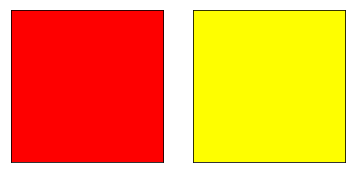

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure()
fig1 = fig.add_subplot(121)
img=mpimg.imread('test.png')
imgplot = plt.imshow(img)
plt.xticks(())
plt.yticks(())

fig2 = fig.add_subplot(122)
img2=mpimg.imread('test2.png')
imgplot = plt.imshow(img2)

plt.xticks(())
plt.yticks(())
plt.show()

## Array interface protocol

* Multidimensional buffers
* Data type information present
* NumPy-specific approach; slowly deprecated (but not going away)
* Not integrated in Python otherwise


[The Array Interface](https://docs.scipy.org/doc/numpy/reference/arrays.interface.html)

In [40]:
x = np.array([[1, 2], [3, 4]])
x.__array_interface__   


{'data': (80710912, False),
 'descr': [('', '<i8')],
 'shape': (2, 2),
 'strides': None,
 'typestr': '<i8',
 'version': 3}

In [43]:
from PIL import Image
img = Image.open('test.png')
img.__array_interface__   

{'data': b'\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\xff\xfe\x00\x00\

In [44]:
x = np.asarray(img)
x.shape

(200, 200, 4)

# Array siblings: chararray, maskedarray, matrix

## [chararray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.chararray.html#numpy.chararray) : vectorized string operations

In [45]:
x = np.array(['a', '  bbb', '  ccc']).view(np.chararray)
x.lstrip(' ')       

chararray(['a', 'bbb', 'ccc'], dtype='<U5')

In [46]:
x.upper() 

chararray(['A', '  BBB', '  CCC'], dtype='<U5')

**Note** `.view() `has a second meaning: it can make an ndarray an instance of a specialized ndarray subclass

## **masked_array** missing data

Masked arrays are arrays that may have missing or invalid entries.

For example, suppose we have an array where the fourth entry is invalid:

In [0]:
x = np.array([1, 2, 3, -99, 5])

One way to describe this is to create a masked array:

In [49]:
mx = np.ma.masked_array(x, mask=[0, 0, 0, 1, 0])
mx

masked_array(data=[1, 2, 3, --, 5],
             mask=[False, False, False,  True, False],
       fill_value=999999)

In [50]:
print(mx.mean())

print(np.mean(mx))

2.75
2.75


!! Not all NumPy functions respect masks, for instance np.dot, so check the return types.

The masked_array returns a view to the original array:

In [51]:
mx[1] = 9
x

array([  1,   9,   3, -99,   5])

### The mask
You can modify the mask by assigning:



In [52]:
mx[1] = np.ma.masked
mx

masked_array(data=[1, --, 3, --, 5],
             mask=[False,  True, False,  True, False],
       fill_value=999999)

The mask is also available directly:

In [53]:
mx.mask

array([False,  True, False,  True, False])

The masked entries can be filled with a given value to get an usual array back:

In [54]:
x2 = mx.filled(-1)
x2

array([ 1, -1,  3, -1,  5])

The mask can also be cleared:

In [55]:
mx.mask = np.ma.nomask
mx

masked_array(data=[1, 9, 3, -99, 5],
             mask=[False, False, False, False, False],
       fill_value=999999)

### Domain-aware functions

The masked array package also contains domain-aware functions:

In [56]:
np.ma.log(np.array([1, 2, -1, -2, 3, -5]))

masked_array(data=[0.0, 0.6931471805599453, --, --, 1.0986122886681098,
                   --],
             mask=[False, False,  True,  True, False,  True],
       fill_value=1e+20)

## [recarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.recarray.html#numpy.recarray): purely convenience

In [60]:
arr = np.array([('a', 1), ('b', 2)], dtype=[('x', 'S1'), ('y', int)])
arr2 = arr.view(np.recarray)
arr2.x

array([b'a', b'b'], dtype='|S1')

In [59]:
arr2.y

array([1, 2])

## [matrix](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.html#numpy.matrix): convenience?

It is no longer recommended to use this class, even for linear algebra. Instead use regular arrays. The class may be removed in the future.|